In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from os import path
from scipy.signal import resample
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
mpl.style.use('seaborn-notebook')
%matplotlib inline
#sorted(mpl.style.available)

# setting up variables
doc_path = "/data/elekin/doc"

coeff=17

%matplotlib inline

In [2]:
#this data has been previously processed by airflow
features = pd.read_csv("/data/elekin/data/results/handwriting/residues_{}_20220905.csv".format(coeff))
features = features.set_index(features.columns[0]).astype(np.float32)
print("Loaded data from CSV")
features.sample(5)

Loaded data from CSV


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
subject_id,,,,,,,,,,,,,,,,,,,,,
T008,0.0,713.452637,71.735992,1673.092163,3281.311523,3791.032959,3467.453125,3209.396484,3349.912842,3518.593506,...,3515.809326,3530.425781,3503.153809,3501.005859,3534.377441,3538.488525,3520.427490,3568.083496,3497.631348,3032.397949
T028_2,0.0,104.067535,82.159348,7.051507,144.884979,190.744583,47.943436,617.654053,1342.587646,1920.241699,...,1803.945923,1741.193359,1638.459351,1615.755859,1731.319458,1906.876831,1966.333862,1781.323730,1410.951660,1099.006348
C106_1,0.0,487.217102,1947.025513,3435.412598,3017.238281,3066.819580,3170.742432,3030.052490,3141.535156,3092.845215,...,3064.392822,3067.335205,3074.963379,3062.576660,3071.883057,3069.473633,3074.495605,3035.312500,3175.231201,2831.010498
C02_2,0.0,173.554779,12.574759,98.943863,6.678424,54.118427,28.924473,67.616440,19.483122,21.156168,...,213.505814,194.441986,200.659439,236.751038,214.852890,193.616058,200.701935,312.150177,216.979355,582.719299
C107_1,0.0,209.938141,33.083900,331.541351,657.759216,2039.291504,3274.517334,3282.774658,2799.424561,2852.664062,...,3605.949463,3404.306885,3391.179443,3643.518066,3610.845459,3280.619385,3389.265625,3884.258057,3611.684326,2268.542969


<AxesSubplot:>

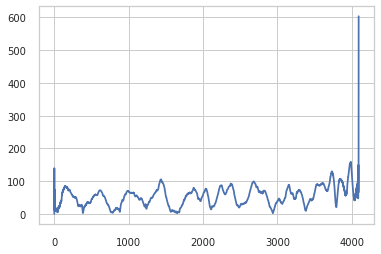

In [3]:
features.loc['C01_1'].plot()

Loading labels based on clinic, residues and features from residues.


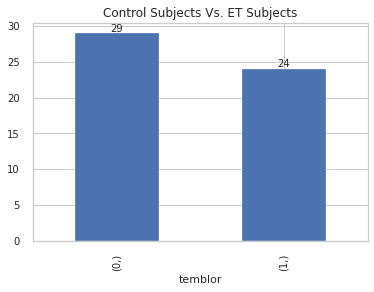

In [4]:
y = pd.read_csv("/data/elekin/data/results/handwriting/binary_labels_20220903.csv", index_col=0)
y = (y == 'si').astype('int8')
ax = y.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

Verify that the data calculated with airflow is correct

In [5]:
features.shape,y.shape

((53, 4096), (53, 1))

In [6]:
denom = 16
l = len(features.T)

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
random_state = 0

X_train=features.rolling(round(l/denom), axis=1).std().dropna(axis=1).values
y_train=y.values.ravel()

In [8]:
# Reduce dimension with LDA
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)
X_train_lda=lda.transform(X_train)

In [9]:
df_lda=pd.DataFrame(X_train_lda, columns=["LDA1"])#temblor
#df_lda=pd.DataFrame(X_train_lda, columns=["component1", "component2"])#level
df_lda["labels"]=y_train
df_lda.head()

,LDA1,labels
0,-2.343789,0
1,-2.582118,0
2,-1.976527,0
3,-2.085611,0
4,-2.776256,0


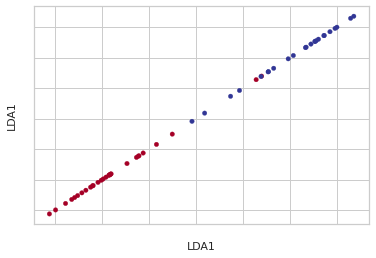

In [10]:
ax = df_lda.plot.scatter(x="LDA1", y="LDA1", c="labels", cmap="RdYlBu", colorbar=False)
ax.xaxis.set_ticklabels([])
_ = ax.yaxis.set_ticklabels([])

In [11]:
# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(),
                    PCA(n_components=3, random_state=random_state))
# Fit the method's model
pca.fit(X_train, y_train)
X_train_pca=pca.transform(X_train)

In [12]:
df_pca=pd.DataFrame(X_train_pca, columns=["PCA0", "PCA1","PCA2"])
df_pca["labels"]=y_train.ravel()
df_pca.head()

,PCA0,PCA1,PCA2,labels
0,-32.713292,-8.453450,-6.681616,0
1,-28.789590,-6.834054,-6.570853,0
2,-26.170202,-4.425808,-7.129038,0
3,-17.960902,-6.695728,-4.510559,0
4,-30.192366,-5.539461,-8.733370,0


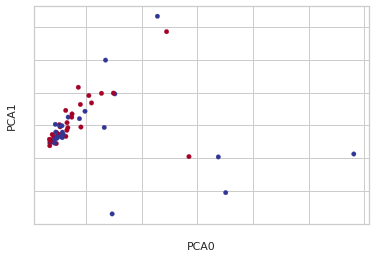

In [13]:
ax = df_pca.plot.scatter(x="PCA0", y="PCA1", c="labels", cmap="RdYlBu", colorbar=False)
ax.xaxis.set_ticklabels([])
_ = ax.yaxis.set_ticklabels([])

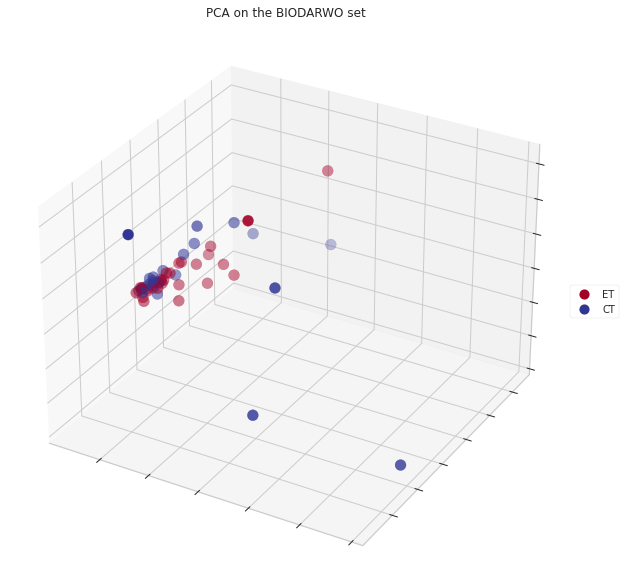

In [14]:
# Plot initialisation
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111, projection='3d')


sc=ax.scatter(df_pca['PCA0'], 
              df_pca['PCA1'], 
              df_pca['PCA2'], c=df_pca.labels, cmap="RdYlBu", s=120)
    
# label the axes
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_zlabel(None)
ax.set_title("PCA on the BIODARWO set")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

colors = [sc.cmap(sc.norm(i)) for i in [0.0, 1.0, 2.0]]

custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                mec='k', mfc=c, mew=.1, ms=20) for c in colors]
import collections
legend = ['ET','CT']#temblor
ax.legend(custom_lines, legend, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

In [15]:
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


score='accuracy'
X = X_train
y = y_train

loo = LeaveOneOut()

In [16]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, y, test_size=0.33, random_state=38)
Counter(ys_train), Counter(ys_test)

(Counter({0: 21, 1: 14}), Counter({0: 8, 1: 10}))

$$ Accuracy: \frac{TP + TN}{TP + TN + FP + FN} $$ 

$$    Recall: \frac{TP}{TP + FN} $$

$$    Precision: \frac{TP}{TP + FP} $$

$$    Specifity: \frac{TN}{TN + FP} $$

Where TP, TN, FP, and FN are, respectively, the true positive, true negative, false positive and false negative values
of the confusion matrix. The positive case corresponds to the ET subjects while the negative case to the CT ones.

**Equations explained**

* Sensitivity/recall – how good a test is at detecting the positives. A test can cheat and maximize this by always returning “positive”. From the whole positive cases how many of them where properly detected.
* Specificity – how good a test is at avoiding false alarms. A test can cheat and maximize this by always returning “negative”.
* Precision – how many of the positively classified were relevant. A test can cheat and maximize this by only returning positive on one result it’s most confident in. 

The cheating is resolved by looking at both relevant metrics instead of just one. E.g. the cheating 100% sensitivity that always says “positive” has 0% specificity.


### SVM-rbf

Leaving one out validation

In [17]:
# predictive model
clf = SVC(kernel='rbf', gamma=0.2, C=10**3)

In [18]:
cv = cross_validate(clf, X, y, cv=loo, scoring=score, return_train_score=True, n_jobs=-1)
print("CV train score svm: {}".format(cv['train_score'].mean()))
print("CV test score svm: {}".format(cv['test_score'].mean()))

CV train score svm: 1.0
CV test score svm: 0.5471698113207547


Hold hout validation

In [19]:
clf.fit(Xs_train, ys_train)
predictions = clf.predict(Xs_test)
#cm = confusion_matrix(ys_test, predictions, labels=clf.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot(cmap=plt.cm.Blues)
#_=plt.axis('off')

In [20]:
print(classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative     0.4444    1.0000    0.6154         8
    Positive     0.0000    0.0000    0.0000        10

    accuracy                         0.4444        18
   macro avg     0.2222    0.5000    0.3077        18
weighted avg     0.1975    0.4444    0.2735        18



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

### RandomForest

Leaving one out validation

In [21]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

cv = cross_validate(clf, X, y, cv=loo, scoring=score, return_train_score=True, n_jobs=-1)

print("CV train score RandomForest: {}".format(cv['train_score'].mean()))
print("CV test score RandomForest: {}".format(cv['test_score'].mean()))

CV train score RandomForest: 1.0
CV test score RandomForest: 0.5849056603773585


Holdout validation

In [22]:
clf.fit(Xs_train, ys_train)
predictions = clf.predict(Xs_test)
#cm = confusion_matrix(ys_test, predictions, labels=clf.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot(cmap=plt.cm.Blues)
#_=plt.axis('off')

In [23]:
print(classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative     0.4615    0.7500    0.5714         8
    Positive     0.6000    0.3000    0.4000        10

    accuracy                         0.5000        18
   macro avg     0.5308    0.5250    0.4857        18
weighted avg     0.5385    0.5000    0.4762        18



### KNN-5

Leaving one out validation

In [24]:
clf = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='euclidean')

cv = cross_validate(clf, X, y, cv=loo, scoring=score, return_train_score=True, n_jobs=-1)

print("CV train score knn: {}".format(cv['train_score'].mean()))
print("CV test score knn: {}".format(cv['test_score'].mean()))

CV train score knn: 0.7529027576197388
CV test score knn: 0.5660377358490566


Holdout validation

In [25]:
clf.fit(Xs_train, ys_train)
predictions = clf.predict(Xs_test)
#cm = confusion_matrix(ys_test, predictions, labels=clf.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot(cmap=plt.cm.Blues)
#_=plt.axis('off')

In [26]:
print(classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative     0.5000    0.8750    0.6364         8
    Positive     0.7500    0.3000    0.4286        10

    accuracy                         0.5556        18
   macro avg     0.6250    0.5875    0.5325        18
weighted avg     0.6389    0.5556    0.5209        18



### LDA

Leaving one out validation

In [27]:
clf.fit(Xs_train, ys_train)
clf = LDA()

cv = cross_validate(clf, X, y, cv=loo, scoring=score, return_train_score=True, n_jobs=-1)

print("CV train score LDA: {}".format(cv['train_score'].mean()))
print("CV test score LDA: {}".format(cv['test_score'].mean()))

CV train score LDA: 0.9274310595065312
CV test score LDA: 0.5471698113207547


Holdout validation

In [28]:
clf.fit(Xs_train, ys_train)
predictions = clf.predict(Xs_test)
#cm = confusion_matrix(ys_test, predictions, labels=clf.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot(cmap=plt.cm.Blues)
#_=plt.axis('off')

In [29]:
print(classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative     0.3750    0.3750    0.3750         8
    Positive     0.5000    0.5000    0.5000        10

    accuracy                         0.4444        18
   macro avg     0.4375    0.4375    0.4375        18
weighted avg     0.4444    0.4444    0.4444        18

